<a href="https://colab.research.google.com/github/makkimaki/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/main/Chapter7_Bayesian_AB_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib
!pip install seaborn==0.12
!pip install numpyro
!pip install 'pymc>=5.9'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az
from numpy.random import multinomial

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.10.3'
sns.__version__='0.12.0'
np.__version__='1.23.5'


##  分布の一般化
- 二項分布⇨多項分布
- ベータ分布⇨ディリクレ分布

In [3]:
P = [0.5, 0.3, 0.2]
N = 1
print(multinomial(N, P))

[0 1 0]


In [4]:
N = 20
print(multinomial(N, P))

[8 5 7]


In [5]:
from numpy.random import dirichlet

sample = dirichlet([1, 1])  # the same as Beta(1, 1)
print(sample)
print(sample.sum())

[0.711 0.289]
1.0


In [6]:
sample = dirichlet([1, 1, 1, 10])
print(sample)
print(sample.sum())

[0.068 0.074 0.071 0.788]
1.0


In [7]:
sample = dirichlet([1, 1, 5, 0.5])
print(sample)
print(sample.sum())

[0.237 0.151 0.524 0.089]
1.0000000000000002


## 共役事前分布
- ディリクレ分布：多項分布の共役事前分布
    - priorがDirichlet(1,1,...,1)、観測が$N_1, N_2, ..., N_m

$\rm{Dirichlet}(1+N_1, 1+N_2, ..., 1+N_m)$

になる


In [8]:
N = 1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)

observations = np.array([N_79, N_49, N_25, N_0])

prior_parameters = np.array([1, 1, 1, 1]) # ここを変えても事後分布はあまり変わらない？
posterior_samples = dirichlet(prior_parameters + observations, size=10000)

# 事後分布から2回サンプリングする
print("Two random samples from the posterior: ")
print(posterior_samples[0])
print(posterior_samples[1])

Two random samples from the posterior: 
[0.017 0.061 0.090 0.831]
[0.016 0.045 0.072 0.867]


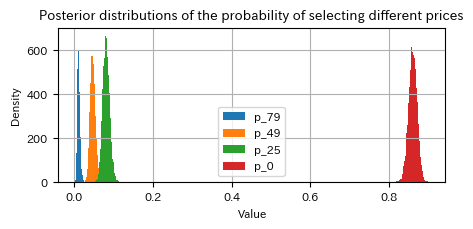

In [9]:
# この事後分布の確率密度
plt.figure(figsize=(5, 2))
for i, label in enumerate(["p_79", "p_49", "p_25", "p_0"]):
    plt.hist(posterior_samples[:, i],
             bins=50,
             label=label,
             histtype="stepfilled"
             )
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior distributions of the probability "
        "of selecting different prices")
plt.legend()
plt.show()

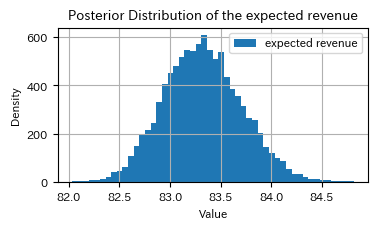

In [10]:
# ディリクレじごぼうンプから得られたサンプルを、以下のexpected_revenueに渡す
def expected_revenue(P):
    return 79 + P[:,0] + 49 * P[:,1] + 25 * P[:,2] + 0 * P[:,3]

posterior_expected_revenue = expected_revenue(P=posterior_samples)
plt.figure(figsize=(4,2))
plt.hist(posterior_expected_revenue,
         histtype="stepfilled",
         bins=50,
         label="expected revenue")  # 期待収益
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior Distribution of the expected revenue")
plt.legend()

期待収益は上記の分布のようになる。その範囲から外に出ることはなさそう。

### A/Bテストへの拡張
２つの契約プランのページA, Bに対する解析へ拡張する。

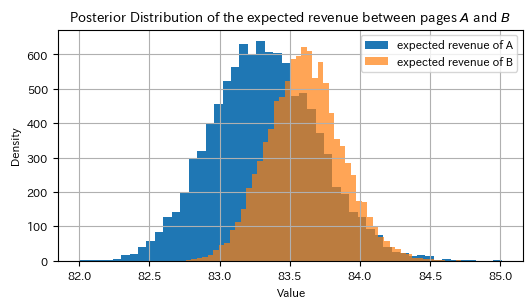

In [11]:
N_A = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_25)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_25)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])

prior_parameters = np.array([1, 1, 1, 1])

posterior_samples_A = dirichlet(prior_parameters + observations_A, size=10000)
posterior_samples_B = dirichlet(prior_parameters + observations_B, size=10000)

posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

plt.figure(figsize=(6,3))
plt.hist(posterior_expected_revenue_A,
         histtype="stepfilled",
         label="expected revenue of A",
         bins=50)
plt.hist(posterior_expected_revenue_B,
         histtype="stepfilled",
         label="expected revenue of B",
         bins=50,
         alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior Distribution of the expected revenue between pages $A$ and $B$")
plt.legend()

サイトBの収益がサイトAの収益より大きい確率は？

In [12]:
P = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()

print(f"Probability that page B has a higher revenue than page A: {P*100:.3f}%")

Probability that page B has a higher revenue than page A: 73.900%


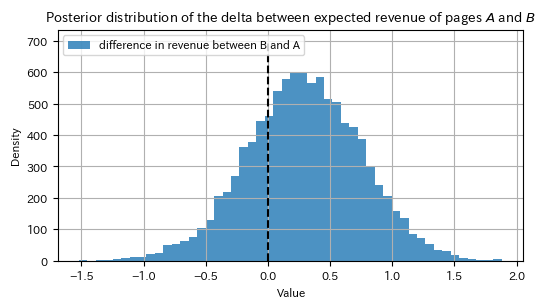

In [13]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A

plt.figure(figsize=(6,3))
plt.hist(posterior_diff,
         histtype="stepfilled",
         bins=50,
         label="difference in revenue between B and A",
         alpha=0.8)
plt.vlines(0, 0, 700, linestyles="--", color="black")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior distribution of the delta between expected revenue of pages $A$ and $B$")
plt.legend(loc="upper left")
plt.show()


上記情報で、**どのぐらいの差がどの程度の確率で出現するか？**がわかるようになる。

### コンバージョン以上の情報を得る：t検定
- 伝統的なt検定は、頻度主義的手法
    - サンプル平均が事前に指定された値からずれているかどうか？の判定
- ベイズ主義⇨例えば、John K. Kruschkeの手法。BEST(Bayesian estimation supersedes the t-test) 論文は誰でも読めるらしい

### t検定の準備
- あるユーザーがテストページにとどまる滞在時間データがあるとする
    - 連続値データ n
    - パラメータは未知であり、出力だけわかる

タスク
- サイトA、サイトBのどちらがユーザーの滞在時間を長くするか決定する
- 5つの未知パラメータ
    - 二つの平均値μと標準偏差σ, t検定パラメータのν
        - ν: データ中に外れ値をどのくらい観測しやすいか

**BESTモデルの事前分布の設定方法**
1. $μ_A, μ_B$のpriorは正規分布。標準偏差はデータの標準偏差の１０００倍にする（=実質的に、無情報事前分布）
2. $\sigma_A, \sigma_B$のpriorは一様分布。データの標準偏差の1/1000 ~ 1000倍
3. $\nu$は右に１だけシフトした指数分布（参考文献: Krushke, "Bayesian Estimation Supersedes the t test") [URL](https://www.sumsar.net/blog/2014/02/bayesian-first-aid-one-sample-t-test/)
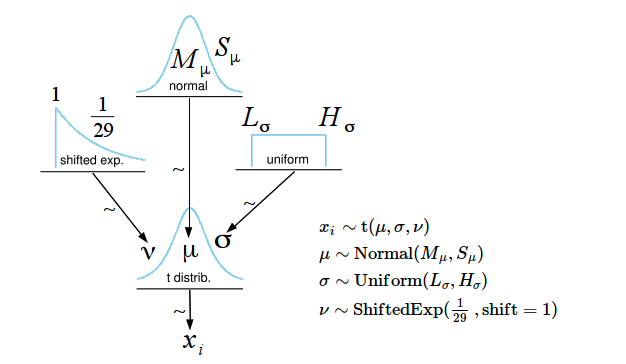



In [14]:
#  人工的データ生成
N = 250
mu_A, std_A = 30, 4
mu_B, std_B = 26, 7

# ユーザーのページ滞在時間
durations_A = np.random.normal(mu_A, std_A, size=N)
durations_B = np.random.normal(mu_B, std_B, size=N)

In [15]:
print(durations_A[:8])
print(durations_B[:8])

[25.719 31.342 30.495 33.339 26.033 33.205 26.943 35.162]
[39.658 39.127 19.906 30.748 33.483 30.740 32.046 17.939]


In [16]:
# 事前分布の設定
pooled_mean = np.r_[durations_A, durations_B].mean()
pooled_std = np.r_[durations_A, durations_B].std()

sigma = pooled_std * 1000
tau = 1. / np.sqrt(sigma)

with pm.Model() as model:
    mu_A = pm.Normal("mu_A", mu=pooled_mean, sigma=tau)
    mu_B = pm.Normal("mu_B", mu=pooled_mean, sigma=tau)
    std_A = pm.Uniform("std_A", pooled_std / 1000, 1000 * pooled_std)
    std_B = pm.Uniform("std_B", pooled_std / 1000, 1000 * pooled_std)

    nu_minus_1 = pm.Exponential("nu-1", lam=1/29)
    # nu = pm.Deterministic('nu', pm.Exponential('nu*', lam=1/29) + 1)

    # 尤度t分布
    obs_A = pm.StudentT("obs_A", mu=mu_A, sigma=std_A, nu=nu_minus_1 + 1, observed=durations_A)
    obs_B = pm.StudentT("obs_B", mu=mu_B, sigma=std_B, nu=nu_minus_1 + 1, observed=durations_B)

model

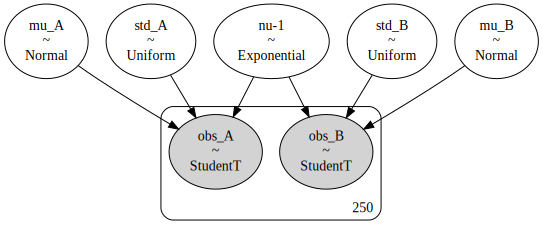

In [17]:
g = pm.model_to_graphviz(model)
display(g)

In [18]:
%%time
with model:
    idata = pm.sample(draws=25000, tune=10000)

CPU times: user 2min 11s, sys: 1.81 s, total: 2min 13s
Wall time: 2min 56s


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


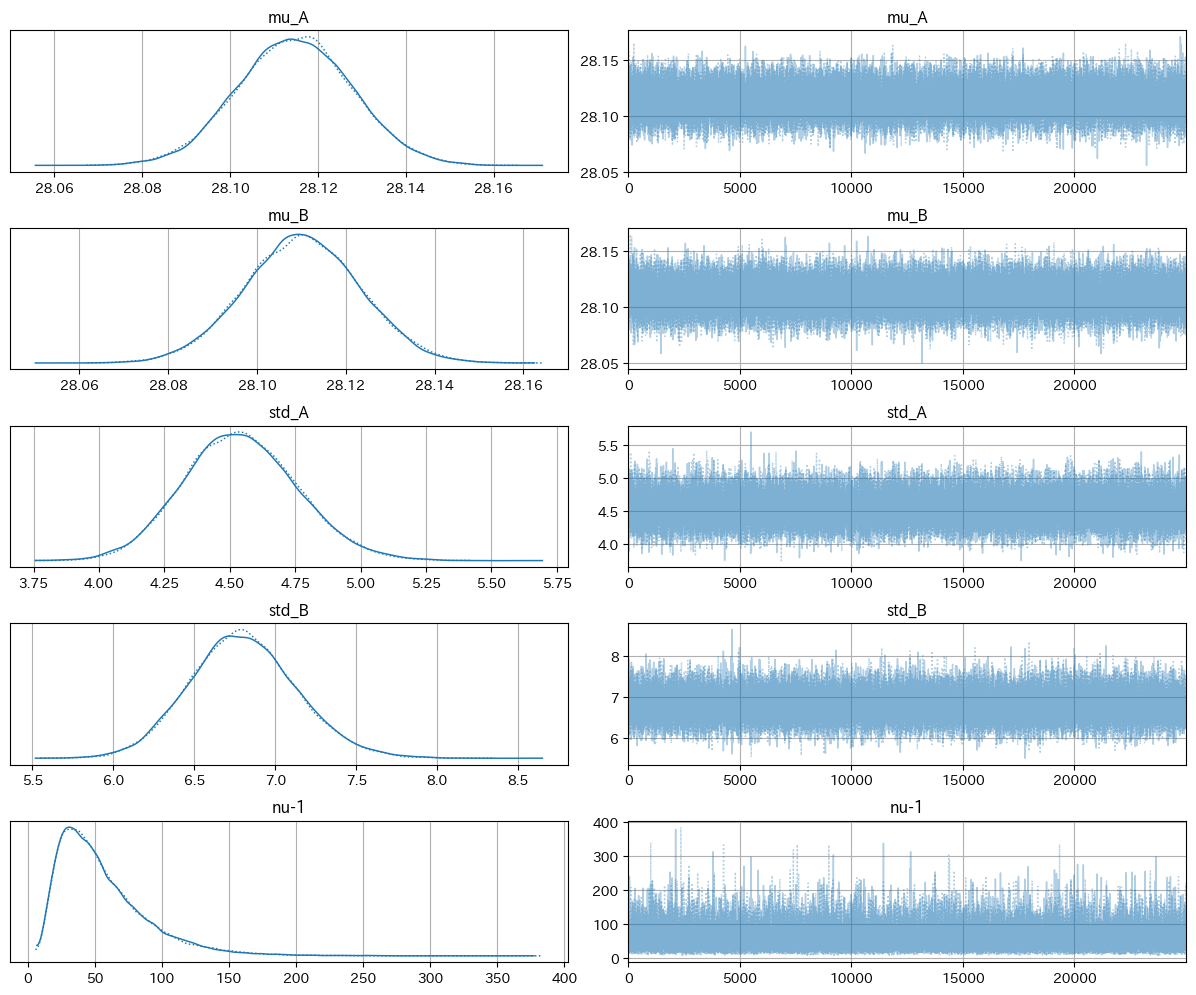

In [20]:
var_names = ["mu_A", "mu_B", "std_A", "std_B", "nu-1"]
pm.plot_trace(idata, var_names=var_names)
plt.tight_layout();

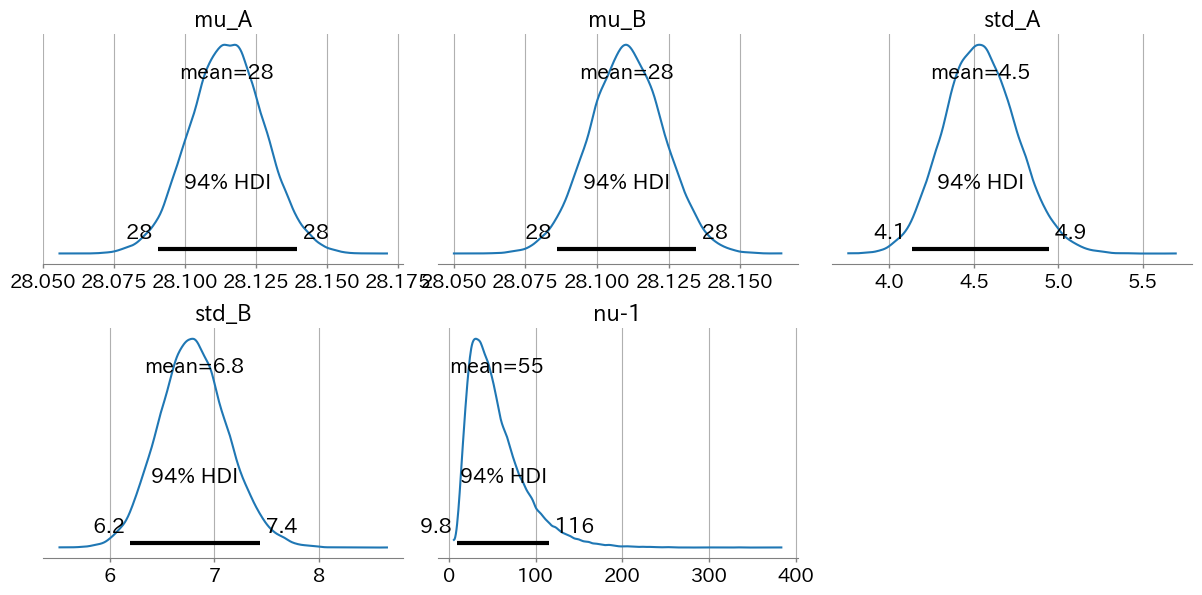

In [21]:
pm.plot_posterior(idata, var_names=var_names, figsize=(12, 6))
plt.tight_layout();

In [22]:
pm.summary(idata, var_names=var_names)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_A,28.115,0.013,28.090,28.139,0.000,0.000,78763.0,41162.0,1.0
mu_B,28.110,0.013,28.086,28.135,0.000,0.000,78584.0,41183.0,1.0
std_A,4.540,0.217,4.131,4.944,0.001,0.001,63745.0,41236.0,1.0
std_B,6.802,0.331,6.193,7.435,0.001,0.001,70810.0,40102.0,1.0
nu-1,55.105,33.382,9.767,115.708,0.140,0.106,56403.0,36881.0,1.0


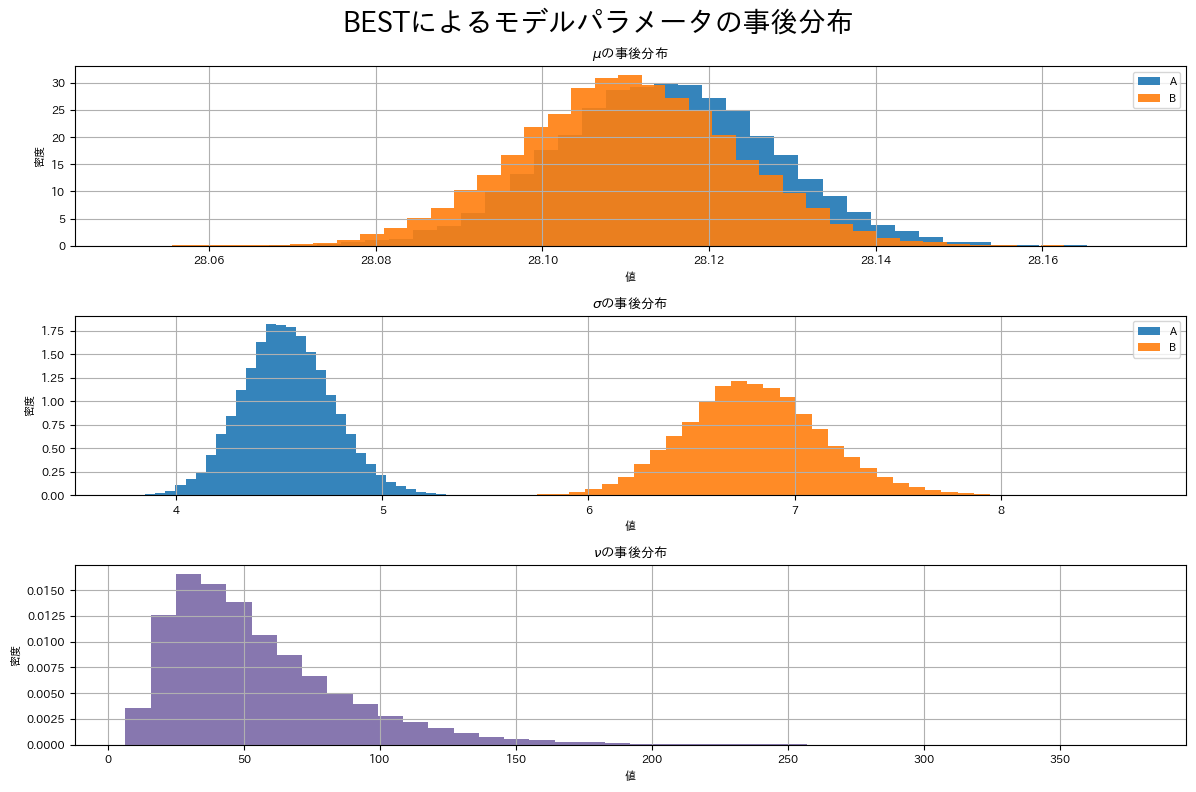

In [23]:
mu_A_trace = idata["posterior"].data_vars["mu_A"].values[0]
mu_B_trace = idata["posterior"].data_vars["mu_B"].values[0]
# print(mu_A_trace)
std_A_trace = idata["posterior"].data_vars["std_A"].values[0]
std_B_trace = idata["posterior"].data_vars["std_B"].values[0]
nu_trace = idata["posterior"].data_vars["nu-1"].values[0]

def _hist(data, label, **kwargs):
    return plt.hist(data, bins=40, histtype="stepfilled", alpha=0.90, label=label, density=True, **kwargs)

# プロットの準備
plt.figure(figsize=(12, 8))

# μの事後分布のヒストグラムの描画
ax = plt.subplot(3, 1, 1)
_hist(mu_A_trace, 'A')
_hist(mu_B_trace, 'B')
plt.xlabel('値')
plt.ylabel('密度')
plt.title(r'$\mu$の事後分布')
plt.legend()

# σの事後分布のヒストグラムの描画
ax = plt.subplot(3, 1, 2)
_hist(std_A_trace, 'A')
_hist(std_B_trace, 'B')
plt.xlabel('値')
plt.ylabel('密度')
plt.title(r'$\sigma$の事後分布')
plt.legend()

# νの事後分布のヒストグラムの描画
ax = plt.subplot(3, 1, 3)
_hist(nu_trace, '', color='#7A68A6')
plt.xlabel('値')
plt.ylabel('密度')
plt.title(r'$\nu$の事後分布')

plt.suptitle('BESTによるモデルパラメータの事後分布', fontsize=20)
plt.tight_layout()
plt.show()

numpyroでも同様のサンプリングするとどれくらい速くなるのか。。

In [24]:
%%time
with model:
    idata = pm.sample(draws=25000, tune=10000, nuts_sampler="numpyro")

  0%|          | 0/35000 [00:00<?, ?it/s]

  0%|          | 0/35000 [00:00<?, ?it/s]

CPU times: user 19.7 s, sys: 399 ms, total: 20.1 s
Wall time: 17.1 s
